# Проект: классификация

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import plotly.express as px

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

### Задание 1

In [82]:
df = pd.read_csv('C:/Users/kotirevar/Desktop/SF Homework/PJ_4_Задача классификации/data/bank_fin.csv', sep = ';')

In [83]:
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,"2 343,00 $",yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,"45,00 $",no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,"1 270,00 $",yes,no,unknown,5,may,1389,1,-1,0,unknown,yes
3,55,services,married,secondary,no,"2 476,00 $",yes,no,unknown,5,may,579,1,-1,0,unknown,yes
4,54,admin.,married,tertiary,no,"184,00 $",no,no,unknown,5,may,673,2,-1,0,unknown,yes


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [85]:
df.isna().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

### Задание 2

In [86]:
df['education'].unique()

array(['secondary', 'tertiary', 'primary', 'unknown'], dtype=object)

### Задание 3

In [87]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
def make_convert(row):
    row = str(row)
    if row != np.NaN:
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(make_convert)

round(df['balance'].mean(), 3)

1529.129

### Задание 4

In [88]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(), 3)

1526.936

### Задание 5

In [89]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения
m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

m_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)


df_balance = df[(df.job == 'management') & (df.education == 'secondary')]

round(df_balance['balance'].mean(), 3)



1598.883

### Задание 6

In [90]:
# удалите все выбросы для признака balance
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return lower_bound, upper_bound, cleaned, outliers

lower_bound, upper_bound, cleaned, outliers = outliers_iqr(df, 'balance')
print(f'Верхняя граница: {upper_bound}')
print(f'Нижняя граница: {lower_bound}')
print(f'Результирующее число записей: {cleaned.shape[0]}')
df = df.drop(outliers.index)

Верхняя граница: 4063.0
Нижняя граница: -2241.0
Результирующее число записей: 10105


## Часть 2:  Разведывательный анализ

### Задание 1

In [91]:
df[df["deposit"] == 'yes'].value_counts()

age  job            marital   education  default  balance  housing  loan  contact    day  month  duration  campaign  pdays  previous  poutcome  deposit
18   student        single    primary    no       608.0    no       no    cellular   12   aug    267       1         -1     0         unknown   yes        1
45   management     married   tertiary   no       226.0    yes      no    cellular   15   feb    91        4          185   6         success   yes        1
     services       single    primary    no       1893.0   yes      no    unknown    3    jun    1259      6         -1     0         unknown   yes        1
                    divorced  secondary  no       608.0    yes      yes   cellular   7    may    1135      3          323   30        failure   yes        1
     self-employed  married   secondary  no       7.0      no       no    cellular   20   nov    691       1         -1     0         unknown   yes        1
                                                               

### Задания 2 и 3

In [92]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат
print(df["age"].max())

print(df["duration"].min())

95
2


### Задания 4 и 5

In [93]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
df["month"].nunique()

df["job"].nunique()


11

### Задание 6

In [94]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.

### Задание 7

In [95]:
group = df.groupby(df['poutcome'] == 'failure', as_index=False)['month'].value_counts()
print(group)

    poutcome month  count
0      False   may   2282
1      False   jul   1376
2      False   aug   1301
3      False   jun   1056
4      False   apr    680
5      False   nov    641
6      False   feb    582
7      False   jan    280
8      False   oct    273
9      False   sep    232
10     False   mar    211
11     False   dec     82
12      True   may    335
13      True   apr    150
14      True   nov    139
15      True   feb    127
16      True   aug     84
17      True   oct     62
18      True   jun     48
19      True   sep     46
20      True   jul     42
21      True   jan     39
22      True   mar     26
23      True   dec     11


### Задание 8

In [96]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения
def get_age (arg):
    if arg < 30:
        return '<30'
    elif (arg >= 30) and (arg < 40):
        return '30-40'
    elif (arg >= 40) and (arg < 50):
        return '40-50'
    elif (arg >= 50) and (arg < 60):
        return '50-60'
    else:
        return '60+'

df['age_new'] = df['age'].apply(get_age)

### Задания 9 и 10

In [97]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

In [98]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования

In [99]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости

### Задание 11

In [100]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

## Часть 3: преобразование данных

### Задание 1

In [101]:
# преобразуйте уровни образования
from sklearn.preprocessing  import LabelEncoder

le = LabelEncoder()
df['education'] = le.fit_transform(df['education'])

df['education'].sum()

11995

### Задания 2 и 3

In [102]:
# преобразуйте бинарные переменные в представление из нулей и единиц
le = LabelEncoder()
df.age_new = le.fit_transform(df.age_new)


def get_binar (arg):
    if arg == 'yes':
        return 1
    else:
        return 0
    

df['deposit'] = df['deposit'].apply(get_binar)
df['default'] = df['default'].apply(get_binar)
df['housing'] = df['housing'].apply(get_binar)
df['loan'] = df['loan'].apply(get_binar)


round(df['deposit'].std(), 3)

round(df['default'].mean()+df['housing'].mean()+df['loan'].mean(), 3)

0.635

### Задание 4

In [103]:
# создайте дамми-переменные

import category_encoders as ce

df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'], drop_first=False)
df.head()


#df = df.drop(['age'], axis=1)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 46 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                10105 non-null  int64  
 1   education          10105 non-null  int32  
 2   default            10105 non-null  int64  
 3   balance            10105 non-null  float64
 4   housing            10105 non-null  int64  
 5   loan               10105 non-null  int64  
 6   day                10105 non-null  int64  
 7   duration           10105 non-null  int64  
 8   campaign           10105 non-null  int64  
 9   pdays              10105 non-null  int64  
 10  previous           10105 non-null  int64  
 11  deposit            10105 non-null  int64  
 12  age_new            10105 non-null  int32  
 13  job_admin.         10105 non-null  uint8  
 14  job_blue-collar    10105 non-null  uint8  
 15  job_entrepreneur   10105 non-null  uint8  
 16  job_housemaid      101

### Задания 5 и 6

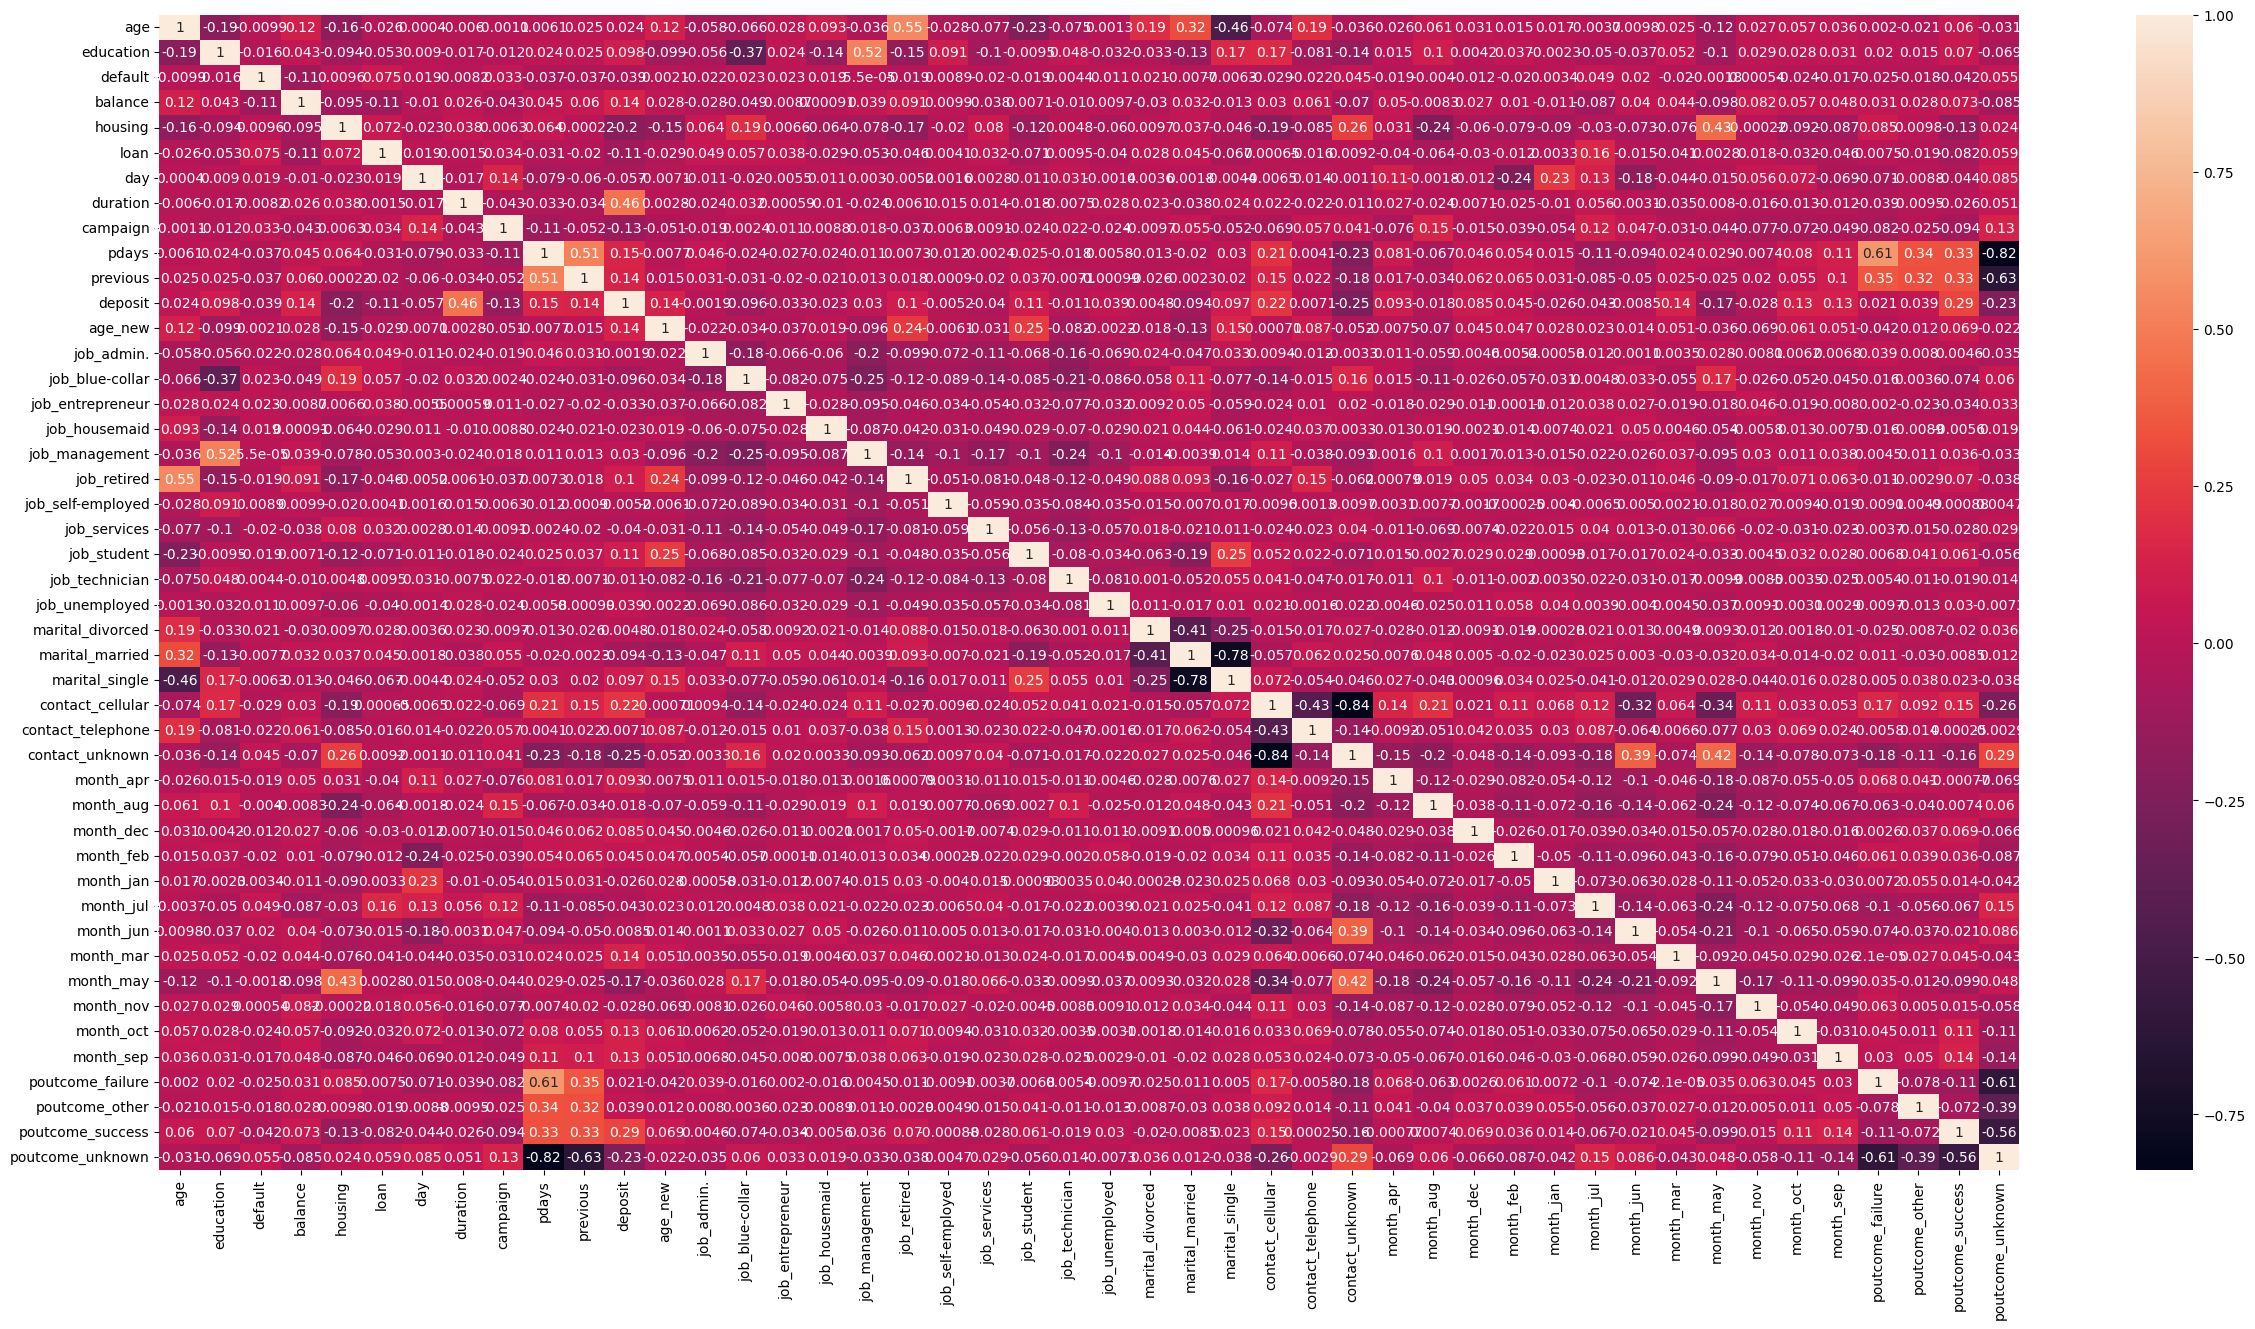

In [104]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize = (30, 15))
sns.heatmap(df.corr(), annot = True);

### Задания 7 и 8

In [105]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)
print('Test:', X_test.shape, y_test.shape)

round(y_test.mean(),2)

Test: (3335, 45) (3335,)


0.46

### Задание 9

In [106]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_classif

# рассчитайте необходимые показатели
selector = SelectKBest(f_classif, k=15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_new', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [107]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_new', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [108]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(round(X_test_scaled[:, 0].mean(),2))

0.47


# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [109]:
# обучите логистическую регрессию и рассчитайте метрики качества
#Создаём объект класса LogisticRegression
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Предсказание
y_pred_1 = log_reg.predict(X_test_scaled)
#Выводим метрику
print(metrics.classification_report(y_test, y_pred_1))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1790
           1       0.83      0.73      0.78      1545

    accuracy                           0.80      3335
   macro avg       0.81      0.80      0.80      3335
weighted avg       0.81      0.80      0.80      3335



### Задания 2,3,4

In [110]:
# обучите решающие деревья, настройте максимальную глубину
dt = tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42,#генератор случайных чисел
    max_depth= 6
)
#Обучаем модель по алгоритму CART
dt.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_2 = dt.predict(X_test_scaled)
#Выводим отчёт о метриках
print(metrics.classification_report(y_test, y_pred_2))

              precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.77      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.81      3335
weighted avg       0.81      0.81      0.81      3335



### Задание 5

In [111]:
from sklearn.model_selection import GridSearchCV

# подберите оптимальные параметры с помощью gridsearch

param = {'min_samples_split': [2, 5, 7, 10],
              'max_depth': [3, 5, 7]
              }
            
grid_search_forest = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(random_state=42), 
    param_grid=param, 
    cv=5, 
    n_jobs = -1
)  
%time grid_search_forest.fit(X_train_scaled, y_train) 
y_test_pred = grid_search_forest.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search_forest.best_params_))



CPU times: total: 203 ms
Wall time: 2.23 s
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 2}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [112]:
# обучите на ваших данных случайный лес
#Создаем объект класса случайный лес
rf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state=42
    )

#Обучаем модель
rf.fit(X_train_scaled, y_train)
y_test_pred = rf.predict(X_test_scaled)
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [113]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом
from sklearn.ensemble import GradientBoostingClassifier

# Создаем объект класса градиентный бустинг
gb = GradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 5,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42 #датчик генератора случайных чисел
)

# Обучаем модель
gb.fit(X_train_scaled, y_train)

# Формируем предсказание для тестовой выборки
y_pred = gb.predict(X_test_scaled)

print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_pred)))

f1_score на тестовом наборе: 0.82


### Задание 4

In [114]:
from sklearn.ensemble import StackingClassifier

# объедините уже известные вам алгоритмы с помощью стекинга 
estimators = [
    ('dt', tree.DecisionTreeClassifier(
    criterion='entropy', #критерий эффективности
    random_state=42,#генератор случайных чисел
    max_depth= 6)
    ),
    ('log_reg',  linear_model.LogisticRegression(
        solver = 'sag', 
        random_state=42, 
        max_iter=1000)
    ),
    ('gb', GradientBoostingClassifier(
    learning_rate = 0.05,
    min_samples_leaf = 5,
    max_depth=5, #максимальная глубина дерева
    n_estimators=300, #количество деревьев в ансамбле
    random_state=42) 
    ) 
]

stack = ensemble.StackingClassifier(
    estimators=estimators, #базовые модели в стекинге
    final_estimator=linear_model.LogisticRegression( #метамодель                 
        random_state=42 #датчик генератора случайных чисел
    )
)
# Обучаем модель
stack.fit(X_train_scaled, y_train)

y_pred_stack = stack.predict(X_test_scaled)

print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_pred)))







precision на тестовом наборе: 0.80


### Задание 5

In [115]:
# оцените, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
random_state = 42

def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=random_state)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score


In [116]:
import optuna
import hyperopt
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials
%%time
# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

UsageError: Line magic function `%%time` not found.


In [117]:
# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=random_state, )
model.fit(X_train_scaled, y_train)

y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))


NameError: name 'study' is not defined

### Задания 6,7,8

In [ ]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna